In [13]:
graphics_toolkit ("gnuplot");

In [3]:
fid = fopen ("NGS_GRAVD_Block_MS01_Gravity_Data_BETA1.txt", "r");
data = textscan (fid,'MS01%d%d%f%f%f%f\n','Delimiter',' ','MultipleDelimsAsOne',1, 'CommentStyle', '/');
lines = [data(1){:}];
datas = cell2mat(cellfun(@double, data(2:end), 'uni', false));
lat = [data(3){:}];
lon = [data(4){:}];
elevation = [data(5){:}]; % meters
obs_grav = [data(6){:}]; %mGal

In [4]:
% GGM Model for height anomalies/ long wavelength undulation
fid = fopen ("GGM02C.gdf", "r");
ggm = textscan (fid,'%f%f%f\n','Delimiter',' ','MultipleDelimsAsOne',1, 'HeaderLines',37);
lon_ggm = [ggm(1){:}]-360;
lat_ggm = [ggm(2){:}];
height_anomaly_gg = [ggm(3){:}]; % meters

In [5]:
% Interpolate GGM lat-lon to GRAV-D lat-lon for height anomaly
height_anomaly_ggm = griddata (lon_ggm,lat_ggm,height_anomaly_gg,lon,lat);

% Calculating Normal Gravity
normal_grav = compute_normal_grav(lat, 'WGS84'); %mGal

% Calculating Free-air Gravity Anomaly
ortho_height = elevation + height_anomaly_ggm;
FAA = compute_free_air_anomaly(obs_grav, lat, ortho_height, 'WGS84'); %mGal

In [6]:
% GGM Model for gravity anomalies
fid = fopen ("GGM02C_gravityanomaly.gdf", "r");
ggm = textscan (fid,'%f%f%f\n','Delimiter',' ','MultipleDelimsAsOne',1, 'HeaderLines',37);
lon_ggm = [ggm(1){:}]-360;
lat_ggm = [ggm(2){:}];
gravity_anomaly_gg = [ggm(3){:}]; % mGal

In [7]:
% Interpolate GGM lat-lon to GRAV-D lat-lon
gravity_anomaly_ggm = griddata (lon_ggm,lat_ggm,gravity_anomaly_gg,lon,lat);

anomaly_smw = FAA - gravity_anomaly_ggm;
atm_correction = compute_atm_correction(ortho_height);
anomaly_smw_atm = anomaly_smw - atm_correction;

In [11]:
%plot inline

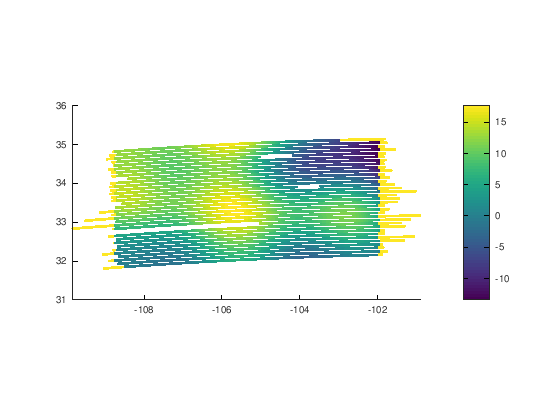

In [14]:
scatter(lon,lat,25,gravity_anomaly_ggm,'filled')
xlim([min(lon) max(lon)]);
daspect ([1 1]);
colorbar;

In [9]:
disp("Creating a grid");
[X, Y, anomaly_grid] = create_grid(anomaly_smw_atm, 0.02, lat, lon);
%mesh(X, Y, anomaly_grid);

Creating a grid


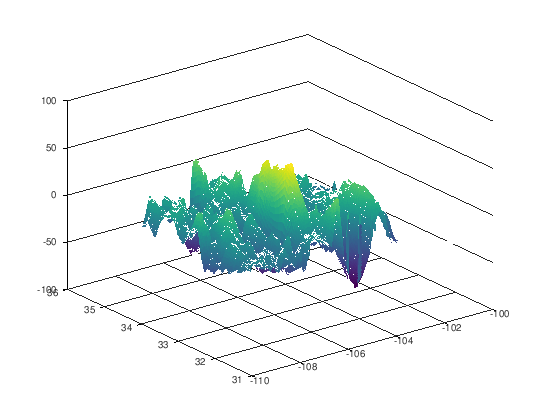

In [15]:
mesh(X, Y, anomaly_grid);

In [11]:
disp("loading DEM");
H = load ("-ascii", "dem_samp.mat");

loading DEM


In [12]:
lat1 = linspace(30,35,6000);
lat2 = linspace(35,40,6000);
latd = [lat1(1:end-1), lat2];
long1  =  linspace(-110,-105,6000);
long2  = linspace (-105,-100,6000);
longd = [long1(1:end-1), long2];
[latm, longm] = meshgrid(latd, longd);

srate = 12;
longm = longm(1:srate:11999,1:srate:11999);
latm = latm(1:srate:11999,1:srate:11999);

H_comb = griddata(latm,longm,H,Y,X);

In [16]:
H_com = H_comb;

In [36]:
save ("-ascii", "H_comb.mat", "H_comb")

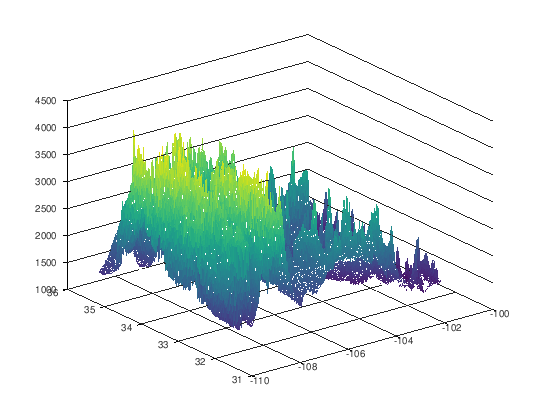

In [17]:
mesh(X, Y, H_comb);

In [18]:
H_comb=addPadding_full(H_comb);

In [20]:
% spacing = 0.02
% xmin = floor(min(long)/0.1)*0.1;
% xmax = ceil(max(long)/0.1)*0.1;
% ymin = floor(min(lat)/0.1)*0.1;
% ymax = ceil(max(lat)/0.1)*0.1;

gridx = X(1,:); #[xmin:spacing:xmax]; % longitude grid spacing
gridy = Y(:,1);  #[ymin:spacing:ymax]; % latitude grid spacing
% [X, Y] = meshgrid(gridx, gridy);
% grid = griddata (lon,lat,mat,X,Y);

lat_range = max(gridy)- min(gridy);
long_range = max(gridx) - min(gridx);
lat1 = [(gridy-lat_range),gridy(1:end),(gridy+lat_range)];
long1 = [(gridx-long_range),gridx(1:end),(gridx+long_range)];


[gridX,gridY]=meshgrid(long1(:),lat1(:));

In [145]:
size(H_comb).*3

ans =

    513   1353



In [158]:
size(gridY)

ans =

    513   1353



In [149]:
size(X)

ans =

   171   451



In [155]:
size(long1)

ans =

      1   1353



In [26]:
Longm=gridX*111319.9*cosd(mean(mean(gridY)));
Latm=gridY*111319.9;
res = 0.02  ;
Mlat=mean(mean(Latm));

r3=(sqrt((Longm-mean(mean(Longm))).^2+(Latm-mean(mean(Latm))).^2)).^3;
r3_inv=1./r3;
r3_inv(r3<111319.9*res)=0;

clear Longm Latm


FR=fft2(r3_inv);
% FR=fft2(fftshift(r3_inv));
FH2=fft2(H_comb.^2);
FH=fft2(H_comb);
F1=fft2(ones(size(FH)));

TCterm1 = ifft2(FR.*FH2);
TCterm2 =  -2*H_comb.*ifft2(FR.*FH);
TCterm3 = (H_comb.^2).*ifft2(FR.*F1);
c = (10^5)*2.67*6.6720e-08/2;
delx = 111319.9*cosd(Mlat)*res;
dely = 111319.9*res;
TC=c*(TCterm1+TCterm2+TCterm3); # *delx*dely
TC = TC(end/3+1:2*end/3,end/3+1:2*end/3);


error: surface: X, Y, and Z must have the same dimensions
error: called from
    surface>__surface__ at line 140 column 11
    surface at line 68 column 21
    mesh at line 83 column 12


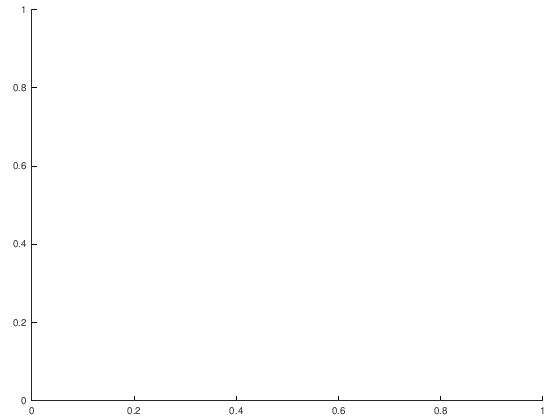

In [22]:
mesh(gridX, gridY, real(TC));

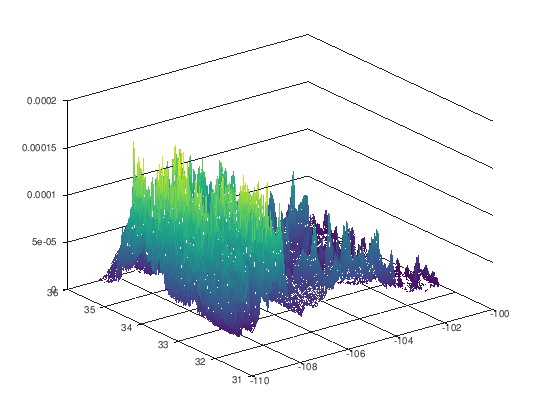

In [27]:
mesh(X, Y, real(TC));

    imshow at line 184 column 5



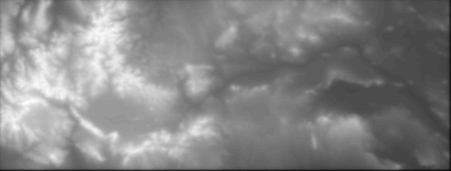

In [27]:
imshow(ifft2(FR.*FH)(end/3+1:2*end/3,end/3+1:2*end/3))

In [40]:
max(H_com(:))

ans = 4270.2


In [24]:
Longm=X*111319.9*cosd(mean(mean(Y)));
Latm=Y*111319.9;
res = 0.02  ;
Mlat=mean(mean(Latm));

r3=(sqrt((Longm-mean(mean(Longm))).^2+(Latm-mean(mean(Latm))).^2)).^3;

disp('FFT kernel for TC')
K=r3;
H=H_com;
FK=K;
clear K
disp('FFT H^2')
FH2=H.^2;
disp('FFT H')
FH=H;
disp('FFT ones')
FOne=ones(size(FK));
%% Compute the terrain correction in mGal for the whole strip
disp('Computing TC')

TCterm1 = conv2(FK,FH2,'same');
TCterm2 =  -2*H.*conv2(FK,FH,'same');
TCterm3 = (H.^2).*conv2(FK,FOne,'same');
c = (10^5)*2.67*6.6720e-08/2;
delx = 111319.9*cosd(Mlat)*res;
dely = 111319.9*res;
TC=c*(TCterm1+TCterm2+TCterm3); 
% *delx*dely

FFT kernel for TC
FFT H^2
FFT H
FFT ones
Computing TC


In [1]:
max(TC(:))

error: 'TC' undefined near line 1, column 1


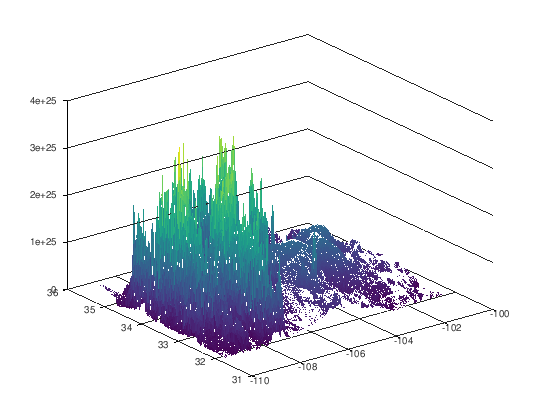

In [25]:
mesh(X, Y, real(TC));

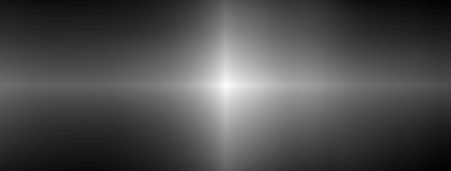

In [106]:
imshow(conv2(FK,FH,'same'))

In [67]:
clear FOne

In [36]:
size(H)

ans =

   171   451

